# MAIO Exercise 3

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import calendar
import xarray as xr
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap
import os

In [112]:
def decimalYearToDateTime(decimalYear):
    """
    function that turns a decimal year into a datetime format
    """
    year = int(decimalYear)
    
    if calendar.isleap(year):
        resDays = int((decimalYear-year)*366)
    else:
        resDays = int((decimalYear-year)*365)
        
    return datetime(year,1,1) + timedelta(days=resDays-1)

def scaleMax(x):
    """
    scale an array with its absolute maximum
    
    Returns
    -------
    x_scaled: the scaled array
    scale: the used scale (absolute maximum)
    """
    scale = np.max(np.abs(x))
    x_scaled = x/scale
    return x_scaled, scale

In [3]:
data_path = "/home/paul/Dokumente/data/maio/ex3/GRACE_CSR_RL06_250km_2003_2016_nomean.nc"

d = xr.open_dataset(data_path,decode_times=False)

time = d['time']
lon =  d['lon']
lat = d['lat']
lon2, lat2 = np.meshgrid(lon,lat)

EWH = d['EWH']

# Task 1
Inspect the data by plotting a number of months. Provide a plot for June 2012, using
a symmetric color scale. As you will see, the data are affected by noise, especially at
lower latitudes. Why is noise less of a problem near the poles?

0

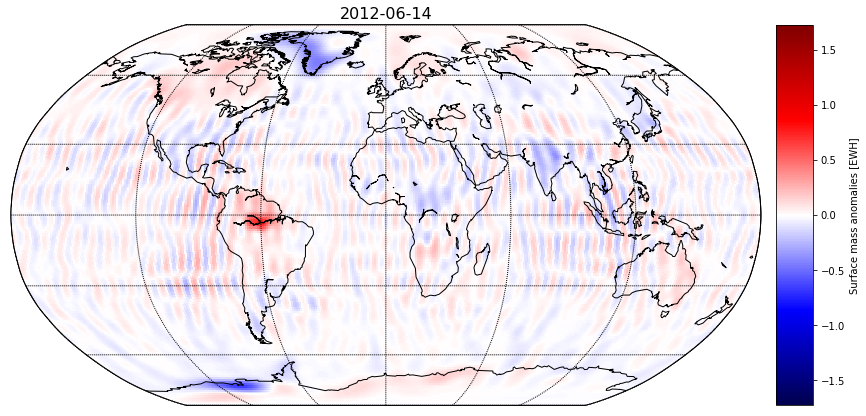

In [88]:
DateIndex = 109
DateString = decimalYeartoDateTime(time[DateIndex]).strftime("%Y-%m-%d")

fig = plt.figure(figsize=(15,7))
plt.title(DateString,fontsize=16)
m = Basemap(projection='robin',lon_0=0,resolution='c')
x, y = m(lon2, lat2)


m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
m.drawmapboundary(fill_color='white')
m.drawcoastlines()

norm_max = np.max(np.abs(EWH))
normEWH = cm.colors.Normalize(vmax=-norm_max, vmin=norm_max)
cmap = cm.seismic
cs = m.pcolormesh(x,y,EWH[DateIndex,:,:],cmap = cmap,norm=normEWH)

cb = m.colorbar(cs)
cb.set_label("Surface mass anomalies [EWH]")

plt.savefig("../img/1.pdf")

os.system("pdfcrop ../img/1.pdf ../img/1.pdf")

# Task 2
Make a plot of the first two EOFs (i.e., the spatial maps) and their PCs (time series).
For each mode, provide an interpretation of what the PCs represent and discuss two
patterns that stand out in the EOFs (one with a positive sign, one with a negative).


In [20]:
# reshape EWH array
len_time, len_lon,len_lat = EWH.shape
EWH_reshaped = np.array(EWH[:,:,:]).reshape(len_time,len_lat*len_lon)

from sklearn.decomposition.pca import PCA

# make pca analysis
pca = PCA(n_components=149)
pca.fit(EWH_reshaped)

PCA(copy=True, iterated_power='auto', n_components=149, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[0.61428082 0.12113445]


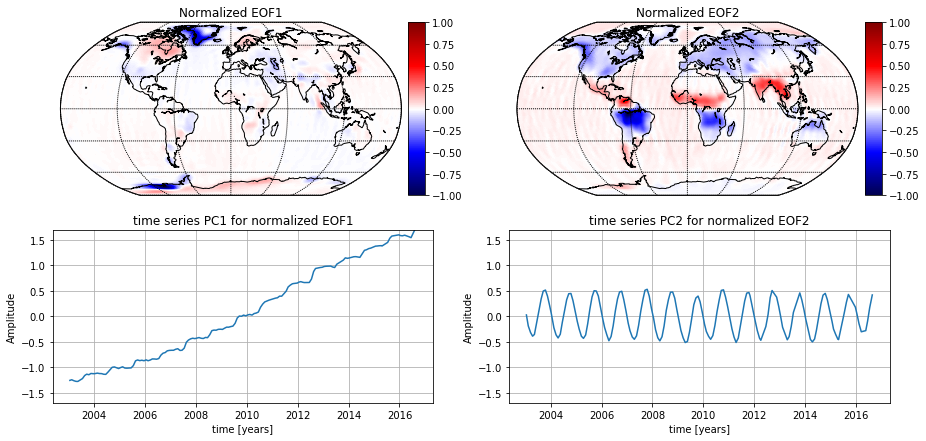

In [111]:
# plot for the first two EOFs
fig = plt.figure(figsize=(15,7))


for i in range(0,2):
    fig.add_subplot(221+i)
    plt.title("Normalized EOF"+str(i+1))
    m = Basemap(projection='robin',lon_0=0,resolution='c')
    x, y = m(lon2, lat2)
    
    m.drawparallels(np.arange(-90.,120.,30.))
    m.drawmeridians(np.arange(0.,360.,60.))
    m.drawmapboundary(fill_color='white')
    m.drawcoastlines()
    
    
    cmap = cm.seismic
    comp, scale = scaleMax(pca.components_[i,:])
    
    norm = cm.colors.Normalize(vmax=-np.max(np.abs(comp)), vmin=np.max(np.abs(comp)))
    cs = m.pcolormesh(x,y,comp.reshape(len_lon,len_lat),cmap = cmap,norm=norm)
    
    cb = m.colorbar(cs)

    
for i in range(0,2):
    
    
    comp, scale = scaleMax(pca.components_[i,:])
    
    projection = np.matmul(EWH_reshaped,pca.components_[i,:]) * scale
    
    fig.add_subplot(223+i)
    plt.plot(time,projection)
    
    plt.title("time series PC"+str(i+1) +" for normalized EOF"+str(i+1))
    plt.xlabel("time [years]")
    plt.ylabel("Amplitude")
    plt.ylim(-1.7,1.7)
    
    plt.grid()
plt.savefig("../img/2.pdf")

os.system("pdfcrop ../img/2.pdf ../img/2.pdf")

print pca.explained_variance_ratio_[:2]

# Task 3
Make plot of the cumulative fraction of explained variance of all modes.


0

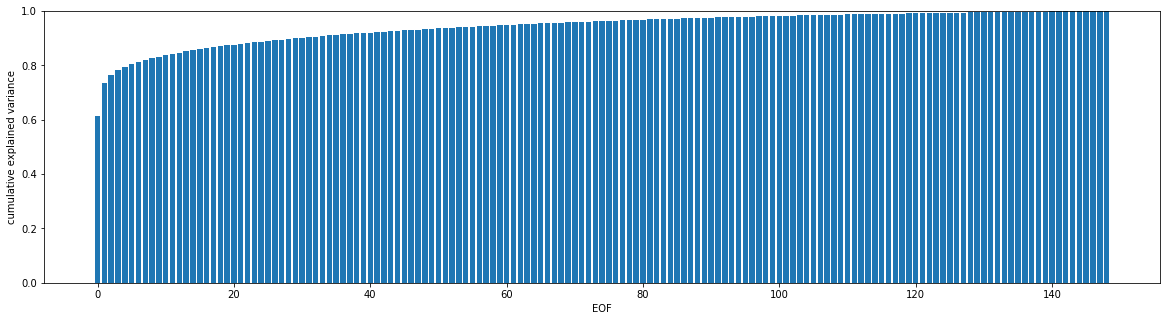

In [85]:
plt.figure(figsize=(20,5))
#plt.plot(np.cumsum(pca.explained_variance_ratio_),marker="x")
plt.bar(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("EOF")
plt.ylabel("cumulative explained variance")

plt.savefig("../img/3.pdf")
plt.ylim(0,1)
os.system("pdfcrop ../img/3.pdf ../img/3.pdf")

# Task 4
Rebuild the data set using modes 1-8. How much of the total variance is contained in
this reconstructed data? Provide a plot of the reconstructed data for June 2012, and
of the difference between the original and reconstructed data. Discuss these
differences.


0

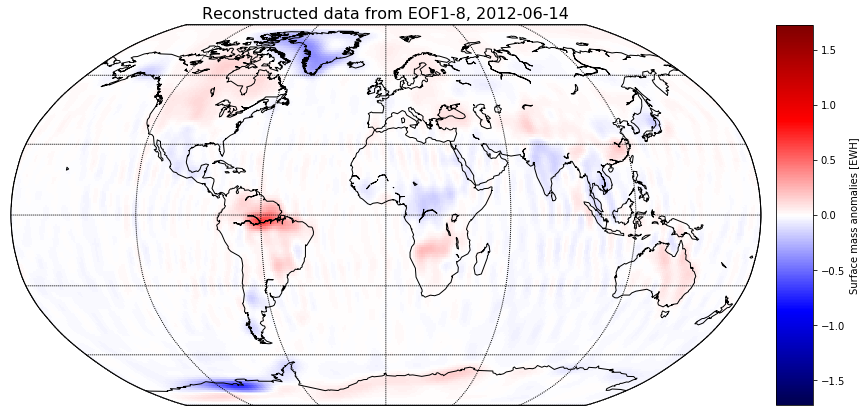

In [91]:
# get the EWH from the first 8 EOF
EOFmax = 8
EWH_from_EOF = xr.zeros_like(EWH[:,:,:])

for t in range(len_time):
    for i in range(EOFmax):
        projection = np.matmul(EWH_reshaped,pca.components_[i,:])
        EWH_from_EOF[t,:,:] = EWH_from_EOF[t,:,:] + projection[t] * pca.components_[i,:].reshape(len_lon,len_lat)
        

# plot the reconstructed EWH        
fig = plt.figure(figsize=(15,7))

plt.title("Reconstructed data from EOF1-8, " +DateString,fontsize=16)
m = Basemap(projection='robin',lon_0=0,resolution='c')
x, y = m(lon2, lat2)

m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
m.drawmapboundary(fill_color='white')
m.drawcoastlines()


cmap = cm.seismic
cs = m.pcolormesh(x,y,EWH_from_EOF[DateIndex,:,:],cmap = cmap,norm=normEWH)

cb = m.colorbar(cs)
cb.set_label("Surface mass anomalies [EWH]")

plt.savefig("../img/4a.pdf")

os.system("pdfcrop ../img/4a.pdf ../img/4a.pdf")

0

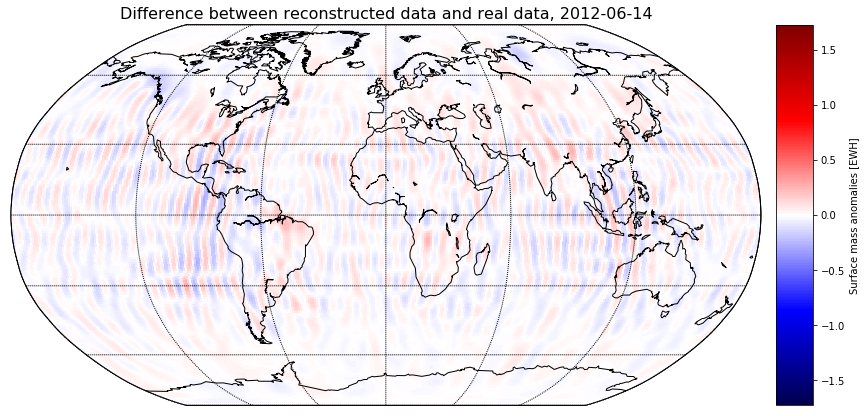

In [92]:
# Plot the difference to the real data
fig = plt.figure(figsize=(15,7))

plt.title("Difference between reconstructed data and real data, "+DateString,fontsize=16)
m = Basemap(projection='robin',lon_0=0,resolution='c')
x, y = m(lon2, lat2)

m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
m.drawmapboundary(fill_color='white')
m.drawcoastlines()


cmap = cm.seismic
cs = m.pcolormesh(x,y,EWH_from_EOF[DateIndex,:,:]-EWH[DateIndex,:,:],cmap = cmap,norm=normEWH)

cb = m.colorbar(cs)
cb.set_label("Surface mass anomalies [EWH]")

plt.savefig("../img/4b.pdf")

os.system("pdfcrop ../img/4b.pdf ../img/4b.pdf")

In [43]:
varData= np.var(EWH)
varEOF = np.var(EWH_from_EOF)
print "Varaince measurements: " + str(np.array(varData))
print "Varaince reconstructed: " + str(np.array(varEOF))
print "portion of variance: " + str(round(np.array(varEOF/varData)*100,2)) + "%"

Varaince measurements: 0.0063742687649500284
Varaince reconstructed: 0.005221174122170214
portion of variance: 81.91%


# Task 5
Plot a time series of the surface mass anomalies at -24.5E, 65.5N in the original and
reconstructed data. Provide an interpretation of the time series and discuss the
differences between the original and reconstructed data.

{'bic':             0           1           2
 0 -659.332767 -658.266569 -653.492951
 1 -658.441613 -653.439271 -653.984335
 2 -653.439930 -654.913313 -650.610299
 3 -648.597681 -643.647894 -644.084423
 4 -643.640896 -645.578928 -640.620864, 'bic_min_order': (0, 0)}

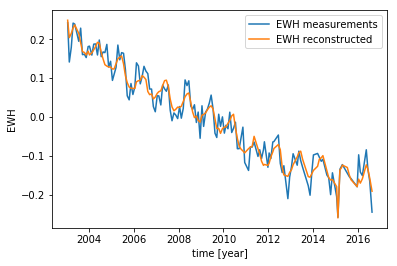

In [113]:
lat_index = np.where(lat==65.5)[0][0]
lon_index = np.where(lon==-25.5)[0][0]
plt.figure()
plt.plot(time,EWH[:,lat_index,lon_index],label="EWH measurements")
plt.plot(time,EWH_from_EOF[:,lat_index,lon_index],label="EWH reconstructed")

plt.xlabel("time [year]")
plt.ylabel("EWH")
plt.legend()

plt.savefig("../img/5.pdf")

os.system("pdfcrop ../img/5.pdf ../img/5.pdf")

# test if white noise -> ARMA order (0,0)
difference = np.array(EWH[:,lat_index,lon_index] - EWH_from_EOF[:,lat_index,lon_index])
from statsmodels.tsa.stattools import arma_order_select_ic
arma_order_select_ic(difference)
